In [1]:
from lolviz import *

In [2]:
class Node:
  def __init__(self, value):
    self.value = value
    self.edges = [] # outgoing edges
  def add(self, target):
    self.edges.append(target)
  def __repr__(self): return str(self.value)

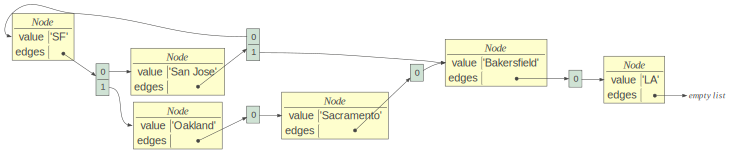

In [3]:
sf = Node("SF")
la = Node("LA")
sac = Node("Sacramento")
oak = Node("Oakland")
baker = Node("Bakersfield")
sj = Node("San Jose")
sf.add(sj)
sj.add(sf)
sj.add(baker)
sf.add(oak)
oak.add(sac)
sac.add(baker)
baker.add(la)

objviz(sf)

# Reachable nodes

We need two sets, one for cycle avoidance and the other to track the nodes we reach. If we used `seen` for both, then `p` would also appear to reach itself, which might not be true.

In [4]:
def reachable(p:Node) -> set:
    reaches = set();
    reachable_(p, reaches, set())
    return reaches

def reachable_(p:Node, reaches:set, visited:set):
    if p in visited: return
    visited.add(p)
    for q in p.edges:
        reaches.add(q)
        reachable_(q, reaches, visited)

In [5]:
reachable(sf)

{Bakersfield, LA, Oakland, SF, Sacramento, San Jose}

In [6]:
reachable(sj)

{Bakersfield, LA, Oakland, SF, Sacramento, San Jose}

In [7]:
reachable(baker)

{LA}

In [8]:
reachable(la)

set()

# Detecting cycles

In [9]:
def iscyclic(p:Node) -> bool:
    return iscyclic_(p,p,set())

def iscyclic_(start:Node, p:Node, visited) -> bool:
    if p in visited: 
        if p is start: return True # we find start?
        return False # can't loop forever so stop
    visited.add(p)
    for q in p.edges:
        c = iscyclic_(start, q, visited)
        if c: return True # we can stop
    return False

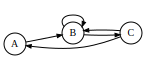

In [10]:
from graphviz import *

edges = """
A -> B
B -> C
C -> A
C -> B
B -> B
"""

graphviz.Source('digraph G {rankdir=LR; ranksep=.5; nodesep=.1; edge [arrowsize=.5]; node [fontsize=10, fixedsize=true, width=.3, height=.3]\n'+edges+'\n}')

In [11]:
A = Node("A")
B = Node("B")
C = Node("C")
A.add(B)
B.add(C)
C.add(A)
C.add(B)
B.add(B)
iscyclic(A), iscyclic(B), iscyclic(C)

(True, True, True)

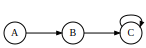

In [12]:
edges = """
A -> B
B -> C
C -> C
"""

graphviz.Source('digraph G {rankdir=LR; ranksep=.5; nodesep=.1; edge [arrowsize=.5]; node [fontsize=10, fixedsize=true, width=.3, height=.3]\n'+edges+'\n}')

In [13]:
A = Node("A")
B = Node("B")
C = Node("C")
A.add(B)
B.add(C)
C.add(C)
iscyclic(A), iscyclic(B), iscyclic(C)

(False, False, True)

## Finding all cycles

Just walk list of nodes and ask iscyclic()

# Find path

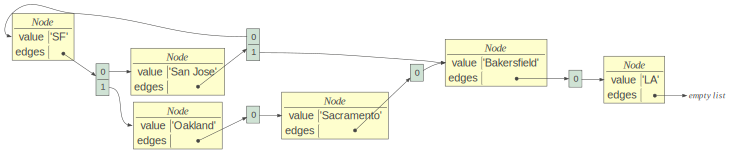

In [14]:
fresno = Node("Fresno")
fresno.add(baker)
objviz(sf)

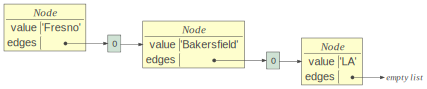

In [15]:
objviz(fresno)

In [16]:
def path(p:Node, q:Node) -> list:
    return path_(p, q, [p], set())

def path_(p:Node, q:Node, path:list, visited:set) -> list:
    if p is q: return path
    if p in visited: return None
    visited.add(p)
    for t in p.edges:
        pa = path_(t, q, path+[t], visited)
        if pa is not None: return pa
    return None

In [17]:
path(sf,la)

[SF, San Jose, Bakersfield, LA]

In [18]:
path(sf,fresno) # no path yields None

In [19]:
path(sf,sf) # node can reach itself by not traversing so path len is 1

[SF]

# All possible paths

In [20]:
def allpaths(p:Node, q:Node) -> list:
    allpaths = []
    allpaths_(p, q, [p], allpaths, set())
    return allpaths

def allpaths_(p:Node, q:Node, path:list, allpaths:list, visited:set):
    if p is q:
        allpaths.append(path)
        return
    if p in visited: return
    visited.add(p)
    for t in p.edges:
        allpaths_(t, q, path+[t], allpaths, visited)
    return None

In [21]:
allpaths(sf,baker)

[[SF, San Jose, Bakersfield], [SF, Oakland, Sacramento, Bakersfield]]

# Labeled edges

In [22]:
class LNode:
  def __init__(self, value):
    self.value = value
    self.edges = {} # outgoing edges
  def add(self, label, target):
    self.edges[label] = target
  def __repr__(self): return str(self.value)

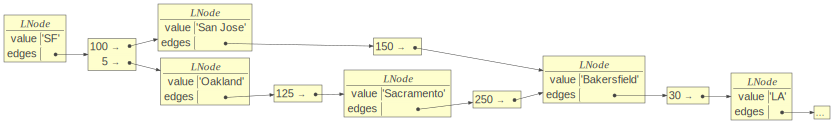

In [23]:
sf = LNode("SF")
la = LNode("LA")
sac = LNode("Sacramento")
oak = LNode("Oakland")
baker = LNode("Bakersfield")
sj = LNode("San Jose")
sf.add(100,sj)
sj.add(150,baker)
sf.add(5,oak)
oak.add(125,sac)
sac.add(250,baker)
baker.add(30,la)

fresno = LNode("Fresno")
fresno.add(60,baker)

objviz(sf)

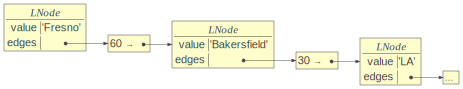

In [24]:
objviz(fresno)

# Breadth-first search

Children first then grandchildren; add to worklist and feed off of that

In [25]:
def BFS(root:Node): 
    visited = {root}
    worklist = [root] 
    while len(worklist)>0: 
        p = worklist.pop(0)
        print(f"Visit {p}")
        # visit all targets of p's edges if not visited
        for q in p.edges:
            if q not in visited:
                print(f"\tAdd {q} to worklist")
                worklist.append(q)
                visited.add(q)

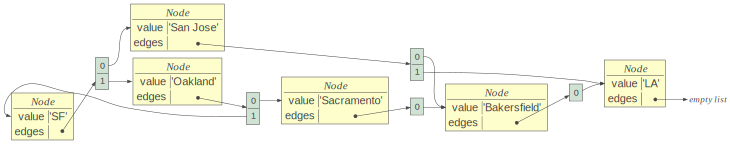

In [26]:
sf = Node("SF")
la = Node("LA")
sac = Node("Sacramento")
oak = Node("Oakland")
baker = Node("Bakersfield")
sj = Node("San Jose")
sf.add(sj)
sj.add(baker)
sf.add(oak)
oak.add(sac)
oak.add(sf)
sac.add(baker)
baker.add(la)
sj.add(la)

objviz(sf)

In [27]:
BFS(sf)

Visit SF
	Add San Jose to worklist
	Add Oakland to worklist
Visit San Jose
	Add Bakersfield to worklist
	Add LA to worklist
Visit Oakland
	Add Sacramento to worklist
Visit Bakersfield
Visit LA
Visit Sacramento


In [28]:
BFS(la)

Visit LA


# Find shortest path (num edges) from p to q

Modify BFS to use work list of paths not nodes

In [29]:
def shortest(root:Node, target:Node): 
    visited = {root}
    worklist = [[root]]
    while len(worklist)>0: 
        path = worklist.pop(0)
        print(f"Process path {path}")
        p = path[-1] # tail of path
        if p is target:
            return path
        for q in p.edges:
            if q not in visited:
                worklist.append(path+[q])
                visited.add(q)

In [30]:
shortest(sf,la)

Process path [SF]
Process path [SF, San Jose]
Process path [SF, Oakland]
Process path [SF, San Jose, Bakersfield]
Process path [SF, San Jose, LA]


[SF, San Jose, LA]

In [31]:
shortest(sf,sj)

Process path [SF]
Process path [SF, San Jose]


[SF, San Jose]

In [32]:
shortest(sj,baker)

Process path [San Jose]
Process path [San Jose, Bakersfield]


[San Jose, Bakersfield]

# Find neighborhood (within k edges)

## Find reachable but track depth

Records first depth at which p reaches q

In [33]:
def depths(p:Node) -> dict:
    reaches = dict()
    depths_(p, reaches, set(), depth=0)
    return reaches

def depths_(p:Node, reaches:dict, visited:set, depth:int):
    if p in visited: return
    visited.add(p)
    reaches[p] = depth
    for q in p.edges:
        depths_(q, reaches, visited, depth+1)

In [34]:
depths(sf)

{SF: 0, San Jose: 1, Bakersfield: 2, LA: 3, Oakland: 1, Sacramento: 2}

## Now find just those within k edges

In [35]:
def neighbors(p:Node, k:int) -> dict:
    reaches = dict()
    neighbors_(p, k, reaches, set(), depth=0)
    return reaches

def neighbors_(p:Node, k:int, reaches:dict, visited:set, depth:int):
    if p in visited or depth>k: return
    visited.add(p)
    reaches[p] = depth
    for q in p.edges:
        neighbors_(q, k, reaches, visited, depth+1)

In [36]:
neighbors(sf, 0)

{SF: 0}

In [37]:
neighbors(sf, 1)

{SF: 0, San Jose: 1, Oakland: 1}

In [38]:
neighbors(sf, 2)

{SF: 0, San Jose: 1, Bakersfield: 2, LA: 2, Oakland: 1, Sacramento: 2}

In [39]:
neighbors(sf, 3)

{SF: 0, San Jose: 1, Bakersfield: 2, LA: 3, Oakland: 1, Sacramento: 2}

## Topological sort

DFS-based topological sort.  A valid sort is the reverse of the post-order DFA traversal.  Amazingly simple but true. 

Let's say that an edge u->v means u must happen before v.

In [40]:
MSDS = """501->690 
502,504,693->601
601->604 
601,604->623
501,502,504->621
691,697,693->603
693->692 
501->694 
501->691 
691->697 
501,692,693->622
621->630 
501,693,601,692->605
605,621,604->625
693->610 
610->696 
630,623,603->631 
501->695 
625,630,622,603,623->632"""

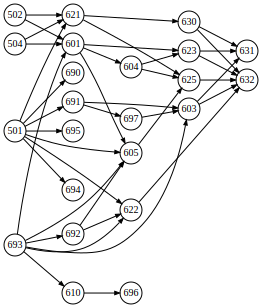

In [41]:
from graphviz import *

graphviz.Source('digraph G {rankdir=LR; ranksep=.5; nodesep=.1; edge [arrowsize=.5]; node [fontsize=10, fixedsize=true, width=.3, height=.3]\n'+MSDS+'\n}')

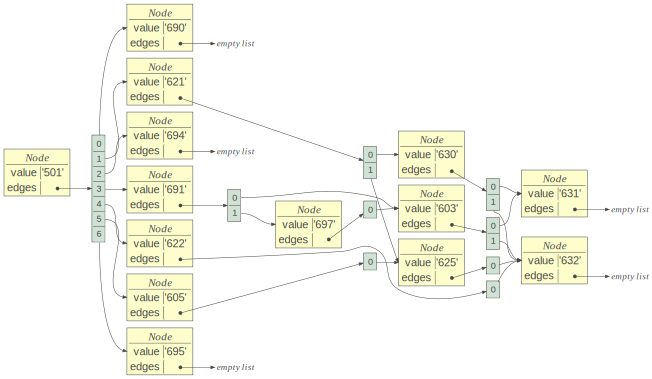

In [42]:
nodes = {}
lines = MSDS.split('\n')
for line in lines:
    line = line.strip()
    left,right = line.split('->')
    if right in nodes:
        target = nodes[right]
    else:
        target = Node(right)
        nodes[right] = target
        
    for u in left.split(','):
        if u in nodes:
            prereq = nodes[u]
        else:
            prereq = Node(u)
            nodes[u] = prereq
        prereq.add(target)
        
# nodes is dictionary mapping from->to
objviz(nodes['501'])

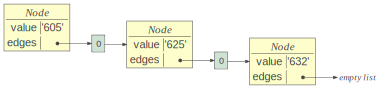

In [43]:
objviz(nodes['605'])

In [44]:
def postorder(p:Node, sorted:list, visited:set):
    if p in visited: return
    visited.add(p)
    for q in p.edges:
        postorder(q, sorted, visited)
    sorted.append(p)

In [45]:
def toposort(nodes):
    sorted = []
    visited = set()
    while len(visited) < len(nodes):
        todo = [node for node in nodes.values() if node not in visited]
        if len(todo)>0:
            postorder(todo[0], sorted, visited)
    return sorted

In [46]:
toposort(nodes)

[690,
 631,
 632,
 630,
 625,
 621,
 694,
 603,
 697,
 691,
 622,
 605,
 695,
 501,
 623,
 604,
 601,
 502,
 504,
 692,
 696,
 610,
 693]

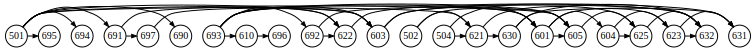

In [47]:
graphviz.Source('digraph G {rankdir=TD; ranksep=.3; nodesep=.15; edge [arrowsize=.5]; node [fontsize=10, fixedsize=true, width=.3, height=.3] {rank=same;\n'+MSDS+'\n}}')

## Another graph

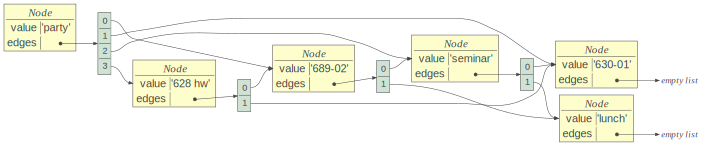

In [48]:
goal = party = Node("party")
cl689 = Node("689-02")
cl630 = Node("630-01")
seminar = Node("seminar")
lunch = Node("lunch")
hw628 = Node("628 hw")

party.add(cl689)
party.add(cl630)
party.add(seminar)
party.add(hw628)

cl689.add(seminar)
seminar.add(cl630)
seminar.add(lunch)
cl689.add(lunch)
hw628.add(cl689)
hw628.add(cl630)

objviz(goal)

In [49]:
sorted = []
postorder(goal, sorted, set())
sorted

[630-01, lunch, seminar, 689-02, 628 hw, party]